# Guardians of the Memory - Modeling - Felix

1. Preprocessing and feature engineering
2. Modeling
    * 2.1. Defining functions
    * 2.2. XGBoost Classifier
    * 2.3. GaussianNB
    * 2.4. Isolation Forest
    * 2.5. XGBoost Regressor
3. Error Analysis

Import Libraries

In [17]:
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import os # Import own functions
import sys
sys.path.append("..") # Fix folder structure
from src.data.preprocessing import load_preprocess_data, train_test_splitter, calculate_target, drop_normalized_cols
from src.features.feature_engineering import unwrap_smart_7, ts_ema, calculate_smart_999, create_features

import pandas as pd # Pandas and Numpy
import numpy as np

import mlflow # MLFlow for experiment tracking
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns # Plotting libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Sklearn for preprocessing and modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor, cv
from sklearn.naive_bayes import GaussianNB

# Sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, precision_recall_curve, mean_squared_error

RSEED = 42 # Random seed for repeatability

## 1. Preprocessing and feature engineering

Load the data

In [18]:
repo_path = os.getcwd()+"/../" # Path to the parent directory
df = load_preprocess_data(path=repo_path) # Load data and preprocessing
df_backup = df.copy()
print("Initial shape:", df.shape)

Initial shape: (462966, 42)


Create features

In [19]:
df = create_features(df, interval=30, trigger_percentage=0.05)
print("Shape after feature engineering", df.shape)

100%|██████████| 608/608 [00:31<00:00, 19.03it/s]


Shape after feature engineering (462966, 64)


Dropping observations and columns
- Not enough drives over 800 days before failure
- Outliers in smart_7_raw

In [20]:
# Remove countdowns over 800
df = df[df.countdown <= 800]
print("Shape after removal of large countdowns:", df.shape)

# Remove smart_7_raw outliers
sn_to_drop = df[df.smart_7_raw > 5e10].serial_number.unique()
for sn in sn_to_drop:
    df.drop(df[df.serial_number == sn].index, inplace=True)
print("Shape after removal of smart_7_raw outlier:", df.shape)

Shape after removal of large countdowns: (418172, 64)
Shape after removal of smart_7_raw outlier: (416073, 64)


## 2. Modeling

### 2.1. Defining functions

In [21]:
def create_train_data(df, feats, days=30, test_size=0.3, random_state=42):
        """Select features, create target and train-test-split

        Args:
            df (_type_): _description_
            feats (_type_): Features to include
            days (int, optional): Time window for target calculation. Defaults to 30.
            test_size (float, optional): Size for train-test-split. Defaults to 0.3.
            random_state (_type_, optional): Random seed. Defaults to 42.

        Returns:
            _type_: Split features and target
        """
        print("Splitting test and train data")
        X = df.copy()[feats]
        y = calculate_target(df, days=days)

        X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
        X_train.drop(["serial_number"], axis=1, inplace=True)
        X_test.drop(["serial_number"], axis=1, inplace=True)
        print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
        print("Shape of the train dataset:", X_train.shape)
        print("Shape of the test dataset:", X_test.shape)
        print("---------------------------------------------------")
        return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test, minmax=True):
        """Scale train and test data

        Args:
            X_train (_type_): X_train
            X_test (_type_): X_test
            minmax (bool, optional): Use minmaxscaling or standard scaling. Defaults to True.

        Returns:
            _type_: Scaled train and test data
        """
        print("Scaling data")
        print("---------------------------------------------------")
        if minmax:
                scaler = StandardScaler()
        else:
                scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test

def log_transform(X_train, X_test):
        """Log transform all features

        Args:
            X_train (_type_): X_train
            X_test (_type_): X_test

        Returns:
            _type_: Transformed data
        """
        print("Log transform features")
        print("---------------------------------------------------")
        return np.log(X_train), np.log(X_test)

def train_eval_model(model, X_train, X_test, y_train, y_test):
        """Train the model, make predictions and evaluate the model

        Args:
            model (_type_): Model including hyperparameters
            X_train (_type_): X_train
            X_test (_type_): X_test
            y_train (_type_): y_train
            y_test (_type_): y_test

        Returns:
            _type_: Fitted model, predictions and probabilities
        """
        print("Fitting")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_proba = model.predict_proba(X_train)
        y_proba = model.predict_proba(X_test)
        fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_test, y_proba[:,1]).round(2)
        recall_test = recall_score(y_test, y_pred).round(2)
        fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
        auc_train = roc_auc_score(y_train, y_train_proba[:,1]).round(2)
        recall_train = recall_score(y_train, y_train_pred).round(2)
        print("---------------------------------------------------")
        print("Model evaluation")
        print("F2 score test (train):", fbeta_test, "(", fbeta_train, ")")
        print("Area under the ROC curve test (train):", auc_test, "(", auc_train, ")")
        print("Recall test (train):", recall_test, "(", recall_train, ")")
        return model, y_pred, y_proba[:,1]

def plot_pr_curve(y_test, y_pred_proba):
        """Plot the precision recall curve and the f2 curve

        Args:
            y_test (_type_): Predictions
            y_pred_proba (_type_): Predicted probabilities

        Returns:
            _type_: F2 scores and the threshold of maximum F2
        """

        pre, rec, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f2 = (5)*(pre*rec)/(4*pre + rec)
        plt.plot(thresholds1, pre[1:],'r-',label = 'Precision Model')
        plt.plot(thresholds1, rec[1:],'b-',label = 'Recall Model')
        plt.plot(thresholds1, f2[1:],'g-',label = 'f2 Model')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Metrics')
        plt.show()
        idx = np.nanargmax(f2)
        return f2, thresholds1[idx]

def predict_threshold(y_pred_proba, threshold=0.5):
        """Make predictions based on a threshold

        Args:
            y_pred_proba (_type_): Predicted probabilities
            threshold (float, optional): Theshold. Defaults to 0.5.

        Returns:
            _type_: _description_
        """
        return y_pred_proba > threshold

def eval_model(y_true, y_pred, y_proba):
        """Calculate the scores of the model

        Args:
            y_true (_type_): True labels
            y_pred (_type_): Predicted labels
            y_proba (_type_): Predicted probabilities
        """
        fbeta_test = fbeta_score(y_true, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_true, y_proba).round(2)
        recall_test = recall_score(y_true, y_pred).round(2)
        print("F2 score test:", fbeta_test)
        print("Area under the ROC curve test:", auc_test)
        print("Recall test:", recall_test)
        return

Scorer for XGBoost and for sklearn gridsearch

In [229]:
def xgb_scorer(predt, dtrain):
    y = dtrain.get_label()
    predt = (predt > threshold)
    return 'f2', fbeta_score(y, predt, beta=2)

ftwo_scorer = make_scorer(fbeta_score, beta=2)

### 2.5. XGBoost Regression

### 2.2 XGBOOST Classification

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.38 ( 0.67 )
Area under the ROC curve test (train): 0.82 ( 0.98 )
Recall test (train): 0.66 ( 0.97 )


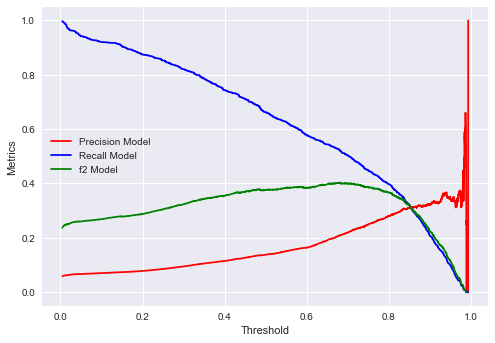

In [94]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = XGBClassifier(  eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        disable_default_eval_metric=True,
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.1, # 0.3, learning rate, lower values to regularize
                        gamma=0.2, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        #n_estimators= , #
                        min_child_weight=1 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # L2 regularization
                        #alpha=0, # L1 regularization
                        #early_stopping_rounds = 100
                        use_label_encoder=False, verbosity=0,
                        )
# Fit and evaluate the model
model, y_pred, y_proba = train_eval_model(model, X_train, X_test, y_train, y_test)
_, threshold = plot_pr_curve(y_test, y_proba)

In [104]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.4
Area under the ROC curve test: 0.82
Recall test: 0.53


### 2.2.1 Additional plots

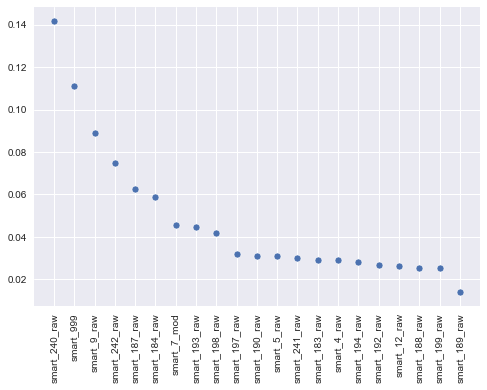

In [25]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.scatterplot(data=feat_importances)
plt.xticks(rotation=90);

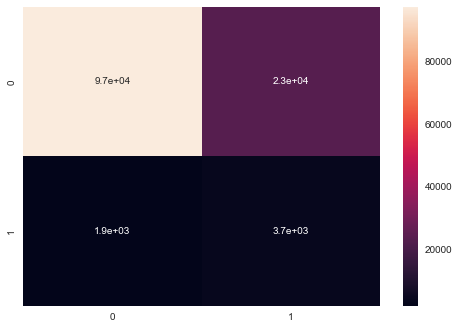

In [26]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

### 2.2.2 CV

[Nice manual I followed](http://ethen8181.github.io/machine-learning/trees/xgboost.html)

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
[0]	validation_0-f2:0.00000	validation_1-f2:0.00000
[1]	validation_0-f2:0.00000	validation_1-f2:0.00000
[2]	validation_0-f2:0.00000	validation_1-f2:0.00000
[3]	validation_0-f2:0.00000	validation_1-f2:0.00000
[4]	validation_0-f2:0.12409	validation_1-f2:0.12269
[5]	validation_0-f2:0.29122	validation_1-f2:0.21650
[6]	validation_0-f2:0.36333	validation_1-f2:0.29922
[7]	validation_0-f2:0.41689	validation_1-f2:0.32323
[8]	validation_0-f2:0.44553	validation_1-f2:0.34631
[9]	validation_0-f2:0.47062	validation_1-f2:0.36282
[10]	validation_0-f2:0.48803	validation_1-f2:0.37966
[11]	validation_0-f2:0.50038	validation_1-f2:0.38672
[12]	validation_0-f2:0.50450	validation_1-f2:0.39676
[13]	validation_0-f2:0.50785	validation_1-f2:0.39800
[14]	validation_0-f2:0.51600	validation_1-f2:0.40929
[15]	validation_0-f2:0.51626	

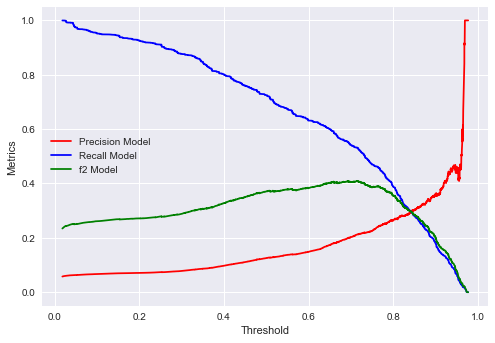

F2 score test: 0.41
Area under the ROC curve test: 0.82
Recall test: 0.53


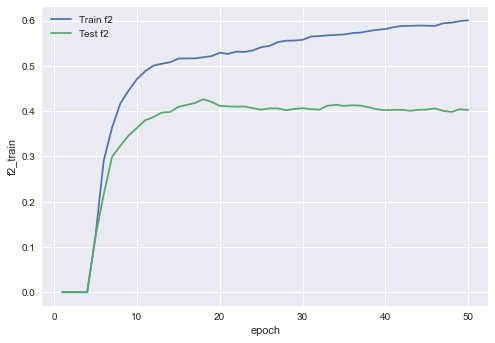

In [246]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Evaluation set to use for cv
eval_s = [(X_train, y_train.values), (X_test, y_test.values)]
# Define the model
model = XGBClassifier(  #eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        disable_default_eval_metric=True,
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.1, # 0.3, learning rate, lower values to regularize
                        gamma=10, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        n_estimators=50 , # 100, number of trees to grow
                        min_child_weight=1 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # 1, L2 regularization
                        #alpha=0, # 0, L1 regularization
                        early_stopping_rounds = 5, #100
                        use_label_encoder=False, verbosity=0,
                        )
# Fit and evaluate the model
evals_result = {}
model.fit(X_train, y_train, eval_set=eval_s, eval_metric=xgb_scorer)
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# Evaluate model
eval_model(y_test, y_pred, y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_test, y_pred_t, y_proba)
# Plot the training results
plotdata = pd.DataFrame({"f2_train": model.evals_result()["validation_0"]["f2"],
                        "f2_test": model.evals_result()["validation_1"]["f2"],
                        "epoch": list(range(1,len(model.evals_result()["validation_0"]["f2"])+1))})
plotdata
sns.lineplot(data=plotdata, x="epoch", y="f2_train")
sns.lineplot(data=plotdata, x="epoch", y="f2_test")
plt.legend(["Train f2", "Test f2"]);

### 2.2.3 Gridsearch

### 2.3. Naive Bayes

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
Log transform features
---------------------------------------------------
Scaling data
---------------------------------------------------
Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.31 ( 0.32 )
Area under the ROC curve test (train): 0.8 ( 0.84 )
Recall test (train): 0.35 ( 0.33 )


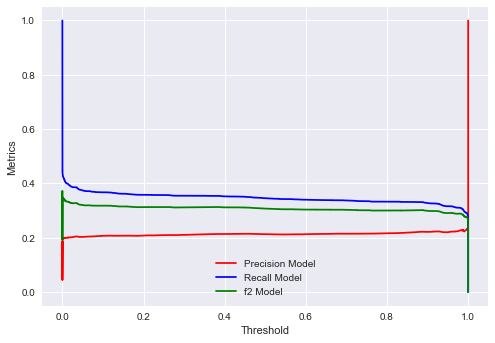

In [55]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
X_train, X_test = log_transform(X_train+1, X_test+1)
X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = GaussianNB(var_smoothing=1e-9)
# Fit and evaluate the model
model, y_pred, y_proba = train_eval_model(model, X_train, X_test, y_train, y_test)
_, threshold = plot_pr_curve(y_test, y_proba)

In [36]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.37
Area under the ROC curve test: 0.8
Recall test: 0.57


### 2.4. Isolation Forest

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
F2 score test: 0.35
Area under the ROC curve test: 0.76
Recall test: 0.56


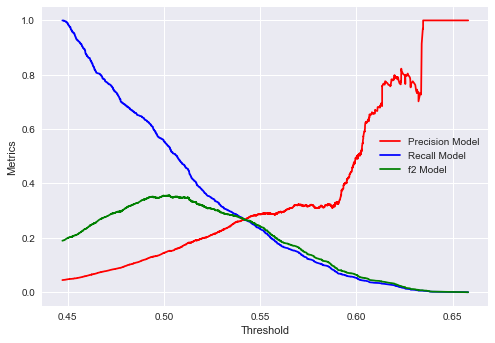

In [29]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = IsolationForest(contamination=3*(y_train.sum()/len(y_train)))
# Fit and evaluate the model
y_pred_train = -1/2*(model.fit_predict(X_train) - 1)
y_pred = -1/2*(model.predict(X_test) - 1)
y_proba = -1/2*(model.decision_function(X_test) - 1)
y_proba_train = -1/2*(model.decision_function(X_test) - 1)
eval_model(y_true=y_test, y_pred=y_pred, y_proba=y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)

In [30]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.36
Area under the ROC curve test: 0.76
Recall test: 0.54


### 2.5. XGBoost Regression

In [31]:
y = df.countdown
X = df.copy()[feats]
X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
X_train.drop(["serial_number"], axis=1, inplace=True)
X_test.drop(["serial_number"], axis=1, inplace=True)
print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
print("Shape of the train dataset:", X_train.shape)
print("Shape of the test dataset:", X_test.shape)

Balance of split: 0.98
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)


In [32]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
y = df.countdown
X = df.copy()[feats]
X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
X_train.drop(["serial_number"], axis=1, inplace=True)
X_test.drop(["serial_number"], axis=1, inplace=True)
print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
print("Shape of the train dataset:", X_train.shape)
print("Shape of the test dataset:", X_test.shape)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = XGBRegressor(  eval_metric="rmse", # Evaluation metric, can use our xgb_scorer
                        disable_default_eval_metric=True,
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.1, # 0.3, learning rate, lower values to regularize
                        gamma=0.2, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        #n_estimators= , #
                        min_child_weight=1 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # L2 regularization
                        #alpha=0, # L1 regularization
                        #early_stopping_rounds = 100
                        use_label_encoder=False, verbosity=0,
                        )
# Fit and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Evluation metrics")
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

Balance of split: 0.98
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
Evluation metrics
RMSE: 175.24986647647518


## 3. Error analysis

For classification

Calculate countdown for test data

In [239]:
y = df.countdown
X = df.copy()[feats]
_, _, _, countdown_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
countdown_test = countdown_test.values

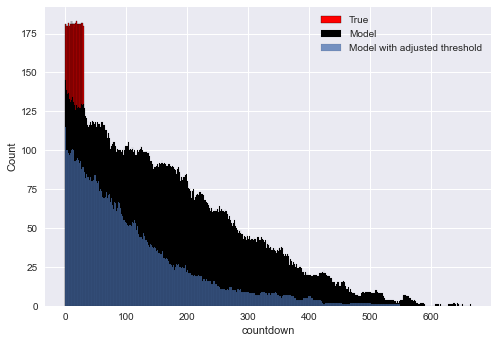

In [247]:
plotdata = pd.DataFrame({"countdown": countdown_test, "y_pred": y_pred, "y_proba": y_proba}).query("y_pred == True")
plotdata_t = pd.DataFrame({"countdown": countdown_test, "y_pred": y_pred_t, "y_proba": y_proba}).query("y_pred == True")
plotdata_test = pd.DataFrame({"y_pred": y_test, "countdown": countdown_test}).query("y_pred == 1")
sns.histplot(data=plotdata_test, x="countdown", bins=int(plotdata_test.max().countdown)+1, color='r', alpha=1)
sns.histplot(data=plotdata[["y_pred", "countdown"]], x="countdown", bins=int(plotdata.max().countdown), color='k', alpha=1)
sns.histplot(data=plotdata_t[["y_pred", "countdown"]], x="countdown", bins=int(plotdata_t.max().countdown))
plt.legend(["True", "Model", "Model with adjusted threshold"]);